# ML2025 Spring HW5 - Kaggle version

### Check GPU Availability

In [1]:
!nvidia-smi

Fri Apr 18 04:28:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Installation

In [2]:
%%capture
# This cell takes about 3-5 minutes
!pip install unsloth==2025.2.15 unsloth_zoo==2025.2.7
!pip install transformers==4.49.0

In [3]:
!git clone https://github.com/ericsunkuan/ML_Spring2025_HW5.git

Cloning into 'ML_Spring2025_HW5'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 10), reused 21 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 12.73 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (10/10), done.


### Unsloth

#### Note : Changing the model is against the Rules of Homework 5 !!!

### Initialize the LLM

In [4]:
!pwd

/kaggle/working


In [5]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

### Changing the model here is forbidden !

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-2-7b-bnb-4bit",    ### Do not change the model for any other models or quantization versions
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-04-18 04:32:09.489513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744950729.683940      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744950729.738594      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: Tesla P100-PCIE-16GB. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [6]:
################# TODO : Tweak the LoRA adapter hyperparameters here.  #####################

model = FastLanguageModel.get_peft_model(
    model,
    r = 16, ### TODO : Choose any number > 0 ! Common values are 4, 8, 16, 32, 64, 128. Higher ranks allow more expressive power but also increase parameter count.
    lora_alpha = 16,  ### TODO : Choose any number > 0 ! Suggested 4, 8, 16, 32, 64, 128


################# TODO  ####################################################################
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.2.15 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [7]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",  ### Use llama-3.1 template for better performance here
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass


# Dataset Preperation (Loading and Refining)

## Data Filtering & Sorting

In [8]:
from datasets import load_dataset, Dataset, load_from_disk

# Load the dataset from Hugging Face
dataset = load_from_disk("/kaggle/working/ML_Spring2025_HW5/fastchat_alpaca_52k")

# ---------------------------
# Add a "text" field to each example
# ---------------------------
# This function extracts the first assistant message from the conversation
def add_text_field(example):
    # Extract the first message where role == 'assistant'
    assistant_texts = [msg["content"] for msg in example["conversations"] if msg["role"] == "assistant"]
    text = assistant_texts[0] if assistant_texts else ""
    return {"text": text}

# Map the function over the dataset to add the "text" column.
dataset = dataset.map(add_text_field)

# Print the dataset structure to confirm the new feature.
print(dataset)


# ---------------------------
#################### TODO : Define a helper function for computing conversation length ###############

# The default "conversation length" here refers to the length of the input (human) and output (gpt), you can modify it at your will

def compute_conversation_length(example):
    # Compute total word count across all messages in the 'conversations' field
    return len(example['conversations'][1]["content"].split())


#################### TODO ############################################################################

# ---------------------------
# Simple Sorting Method  (Default)
# ---------------------------
# Sort the dataset from shortest to longest conversation (by word count)
sorted_dataset_simple_list = sorted(dataset, key=compute_conversation_length, reverse=True)

# Convert back to a Dataset object
sorted_dataset_simple = Dataset.from_list(sorted_dataset_simple_list)

print("\nTop examples sorted by simple conversation length:")
for entry in sorted_dataset_simple.select(range(5)):
    print(f"ID: {entry['id']}, Conversation Length: {compute_conversation_length(entry)}")
# ---------------------------



############## Advanced Sorting Method (TODO : Modify the sorting key ##################
# ---------------------------
# Default : Sorting based on Combining conversation length with the 'score' field using a weighted sum.
# Here, we multiply the conversation length by 1e-5 and add it to the score.
def advanced_sort_key(example):
    conversation_len = compute_conversation_length(example)
    score = example["score"]
    return 1e-5 * conversation_len + score * 1

####################################### TODO ###########################################

sorted_dataset_advanced_list = sorted(dataset, key=advanced_sort_key, reverse=True)
# Convert back to a Dataset object
sorted_dataset_advanced = Dataset.from_list(sorted_dataset_advanced_list)

print("\nTop examples sorted by advanced key (combination of conversation length and score):")
for entry in sorted_dataset_advanced.select(range(5)):
    print(f"ID: {entry['id']}, Advanced Key Value: {advanced_sort_key(entry)}")


Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'conversations', 'score', 'text'],
    num_rows: 52002
})

Top examples sorted by simple conversation length:
ID: identity_45289, Conversation Length: 717
ID: identity_6285, Conversation Length: 625
ID: identity_15102, Conversation Length: 597
ID: identity_18853, Conversation Length: 544
ID: identity_15908, Conversation Length: 525

Top examples sorted by advanced key (combination of conversation length and score):
ID: identity_40362, Advanced Key Value: 5.00015
ID: identity_8015, Advanced Key Value: 5.00007
ID: identity_9103, Advanced Key Value: 5.00006
ID: identity_30813, Advanced Key Value: 5.00005
ID: identity_37225, Advanced Key Value: 5.00004


#### Note : You are limited to use 100 sorted data among the 1000 data in the given dataset, no more than 100 data is allowed for training !!!

In [9]:
################# TODO : select the simple or advanced dataset for training ##############

dataset_used = "sorted_dataset_simple" #sorted_dataset_advanced

################# TODO ###################################################################

if dataset_used == "sorted_dataset_simple":
    train_dataset = sorted_dataset_simple.select(range(20,120))    ### You can also select from the middle, e.g. sorted_dataset_simple.select(range(50,150))
else:
    train_dataset = sorted_dataset_advanced.select(range(0,100))

from unsloth.chat_templates import standardize_sharegpt
train_dataset = standardize_sharegpt(train_dataset)
train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)

Standardizing format:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Dataset Visualize

In [10]:
# dataset[5]["conversations"]

# Extract conversation lengths and scores
conversation_lengths = [compute_conversation_length(example) for example in dataset]
scores = [example['score'] for example in dataset]
advanced_keys = [advanced_sort_key(example) for example in dataset]

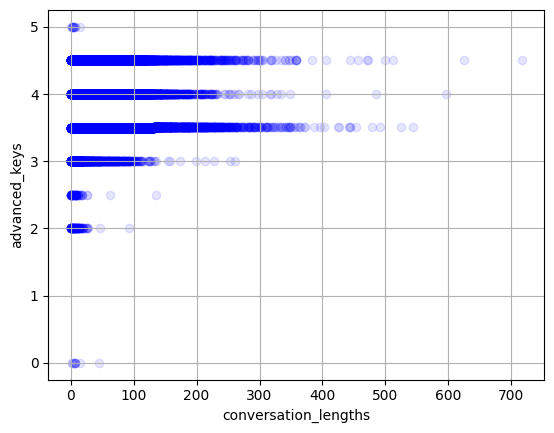

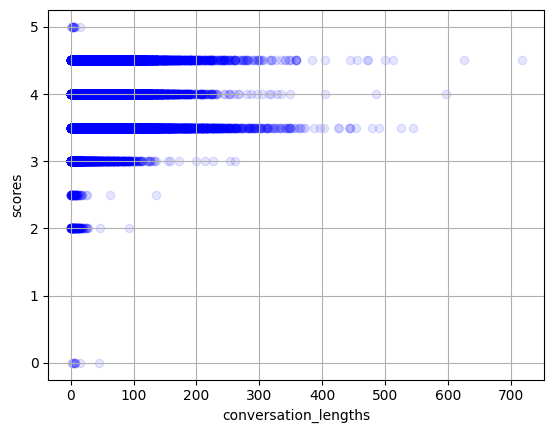

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt


# Plot the data
# plt.plot(conversation_lengths)
# plt.plot(scores)
# plt.plot(advanced_keys)
plt.scatter(conversation_lengths, advanced_keys, alpha=0.1, color='blue')
# plt.scatter(advanced_keys, scores, alpha=0.1, color='blue')
plt.xlabel('conversation_lengths')
plt.ylabel('advanced_keys')
# plt.xlabel('Custom key', fontsize=14)
# plt.ylabel('Score', fontsize=14)
plt.grid(True)
plt.show()
plt.close()
plt.scatter(conversation_lengths, scores, alpha=0.1, color='blue')
plt.xlabel('conversation_lengths')
plt.ylabel('scores')
plt.grid(True)
plt.show()

And we see how the chat template transformed these conversations.

**[Notice]** Llama 3.1 Instruct's default chat template default adds `"Cutting Knowledge Date: December 2023\nToday Date: 26 July 2024"`, so do not be alarmed!

In [12]:
print(compute_conversation_length(dataset[0]))
print(dataset[0]['conversations'][1]["content"].split())

34
['1.Eat', 'a', 'balanced', 'diet', 'and', 'make', 'sure', 'to', 'include', 'plenty', 'of', 'fruits', 'and', 'vegetables.', '2.', 'Exercise', 'regularly', 'to', 'keep', 'your', 'body', 'active', 'and', 'strong.', '3.', 'Get', 'enough', 'sleep', 'and', 'maintain', 'a', 'consistent', 'sleep', 'schedule.']


## Training

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported


################# TODO : Tweak the training hyperparameters here.  #####################


training_config = {
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 4,
    "warmup_steps": 10,
    "num_train_epochs": 5,
    "learning_rate": 2e-4,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "cosine",
    "seed": 1126,   ### Do not modify the seed for reproducibility
}


################# TODO #################################################################

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = training_config["per_device_train_batch_size"],
        gradient_accumulation_steps = training_config["gradient_accumulation_steps"],
        warmup_steps = training_config["warmup_steps"],
        num_train_epochs = training_config["num_train_epochs"], # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = training_config["learning_rate"],
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = training_config["optim"],
        weight_decay = training_config["weight_decay"],
        lr_scheduler_type = training_config["lr_scheduler_type"],
        seed = training_config["seed"],
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [14]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 100 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 39,976,960


Step,Training Loss
1,1.171500
2,1.043400
3,1.149000
4,0.889700
5,1.195000
6,1.278500
7,1.135500
8,1.299300
9,1.396500
10,1.277500


#### TODO : Curriculum Training  (Optional)
start training the LLM with “easier” examples (e.g., shorter, clearer conversations) and progressively introduce more complex ones.

The total data amount used to train should still not exceed 100 data.

In [16]:
############## TODO : Curriculum Training  ######################

### E.g.
### Step 1. Train on sorted_dataset_simple
### Step 2. Train on sorted_dataset_advanced

<a name="Inference"></a>
## Inference


In [17]:
def parse_true_output(text):
    """
    Extracts the true assistant output from the decoded model output.

    It looks for the assistant header token:
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
    and extracts everything after it until the first occurrence of "<|eot_id|>".
    If the assistant header is not found, it falls back to the last occurrence
    of "<|end_header_id|>\n\n". If "<|eot_id|>" is not found, the extraction
    continues until the end of the string.
    """
    assistant_header = "<|start_header_id|>assistant<|end_header_id|>\n\n"
    start_index = text.find(assistant_header)
    if start_index != -1:
        start_index += len(assistant_header)
    else:
        # Fallback: use the last occurrence of the generic header ending
        generic_header = "<|end_header_id|>\n\n"
        start_index = text.rfind(generic_header)
        if start_index != -1:
            start_index += len(generic_header)
        else:
            start_index = 0

    end_index = text.find("<|eot_id|>", start_index)
    if end_index == -1:
        end_index = len(text)
    return text[start_index:end_index].strip()

In [18]:
from unsloth.chat_templates import get_chat_template
import json
from datetime import datetime

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# Load the test set JSON file (without GPT responses)
with open("/kaggle/working/ML_Spring2025_HW5/test_set_evol_instruct_150.json", "r") as infile:
    test_data = json.load(infile)

# Dictionary to store inference results
inference_results = {}

# Loop over each data entry in the test set
for index,entry in enumerate(test_data):
    entry_id = entry.get("id", "unknown_id")

    # Build the messages list from the human conversation entries
    # (Test set is expected to have only "human" messages)
    messages = []
    for conv in entry.get("conversations", []):
        if conv.get("from") == "human":
            messages.append({"role": "user", "content": conv.get("value", "")})
        else:
            messages.append({"role": "assistant", "content": conv.get("value", "")})

    # Create inputs using the chat template (required for generation)
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Must add for generation
        return_tensors="pt",
    ).to("cuda")


################# TODO : Tweak Decoding Parameters here.  #####################


    # Generate model outputs
    outputs = model.generate(
        input_ids=inputs,
        do_sample=True,
        max_new_tokens=500,
        use_cache=True,
        temperature=1,
        top_p = 0.5,
        top_k = 3,
    )


################# TODO  ##########################################################

    # Decode the generated tokens
    decoded_outputs = tokenizer.batch_decode(outputs)

    # Parse each output to extract the true assistant response
    parsed_outputs = [parse_true_output(output) for output in decoded_outputs]

    # Store the result for the current entry
    inference_results[entry_id] = {
        "input": messages,
        "output": parsed_outputs
    }

    print(f"Inference completed for entry {entry_id}")
    
# Write the inference results to the prediction JSON file
with open(f"pred.json", "w") as outfile:
    json.dump(inference_results, outfile, indent=4)
with open(f"training_config.json", "w") as outfile:
    json.dump(training_config, outfile, indent=4)

# Download your prediction file
from IPython.display import HTML, Javascript

def create_download_link(filename):
    html = f'''
    <a href="{filename}" download="{filename}">Click here to download your {filename}</a>
    '''
    return HTML(html)



print("Inference completed for all entries in the test set.")
create_download_link("pred.json")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Inference completed for entry identity_8174
Inference completed for entry identity_16675
Inference completed for entry identity_51749
Inference completed for entry identity_53196
Inference completed for entry identity_65799
Inference completed for entry identity_31686
Inference completed for entry identity_25291
Inference completed for entry identity_31699
Inference completed for entry identity_30359
Inference completed for entry identity_67085
Inference completed for entry identity_60450
Inference completed for entry identity_3070
Inference completed for entry identity_36778
Inference completed for entry identity_50478
Inference completed for entry identity_20143
Inference completed for entry identity_8300
Inference completed for entry identity_45513
Inference completed for entry identity_62606
Inference completed for entry identity_38166
Inference completed for entry identity_22233
Inference completed for entry identity_54369
Inference completed for entry identity_39141
Inference com

## Saving, loading finetuned models

### Save the model

In [19]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

### Load the model

In [20]:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model", # The folder path containing of the folder that contains adapter_model.safetensors, adapter_config.json and README.md
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: Tesla P100-PCIE-16GB. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Line